# 1. XLM-R

In [ ]:
pip install transformers

     |████████████████████████████████| 2.1MB 7.4MB/s 
     |████████████████████████████████| 901kB 33.5MB/s 
     |████████████████████████████████| 3.3MB 52.6MB/s 


In [ ]:
import torch
import pandas as pd
import numpy as np

# Transformer lib for Classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
# Label processing
from sklearn.preprocessing import LabelEncoder

# Evaluation metrics
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Plot
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# Building data  
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read dataset

train = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/NLP_KHDL/ThucHanh_23042021/dataset/train_nor_811.xlsx", index_col=False)
dev = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/NLP_KHDL/ThucHanh_23042021/dataset/valid_nor_811.xlsx", index_col=False)
test = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/NLP_KHDL/ThucHanh_23042021/dataset/test_nor_811.xlsx", index_col=False)

X_train = train['Sentence']
y_train = train['Emotion'].values

X_dev = train['Sentence']
y_dev = train['Emotion'].values

X_test = train['Sentence']
y_test = train['Emotion'].values

print(len(train))
print(len(dev))
print(len(test))

5548
686
693


In [ ]:
dev.head(10)

,Unnamed: 0,Emotion,Sentence
0,941,Other,"tính tao tao biết , chẳng có chuyện gì có thể ..."
1,142,Enjoyment,"lại là lào cai , tự hào quê mình quá :))"
2,1164,Sadness,bị từ chối rồi
3,182,Enjoyment,tam đảo trời đẹp các mem à
4,868,Other,đọc bình luận của thằng đó không thiếu chữ nào 😂😂
5,236,Enjoyment,crush tao vẫn còn trinh nhé 😘
6,1229,Anger,nó nói không đúg ư . đg của nhà bà ư . nó đóg ...
7,355,Fear,gap kiểu này chắc đái ra quần quá
8,1538,Enjoyment,yêu em mọa mọa 😘😘
9,536,Sadness,có ai như tao không đọc đề thì quen nhưng lại ...


In [ ]:
np.unique(y_test)

array(['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Other', 'Sadness',
       'Surprise'], dtype=object)

In [ ]:
# Pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels = 7)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
# Label encoding  
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
# Data encoding
train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
test_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
y_test_encoding = le.transform(y_test)

In [ ]:
# Data preparing

train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
# Model preparing

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
# Training

trainer.train()

Step,Training Loss
500,1.781500
1000,1.686200


TrainOutput(global_step=1041, training_loss=1.728737830199609, metrics={'train_runtime': 192.0456, 'train_samples_per_second': 5.421, 'total_flos': 497925958478400.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 1520324608, 'init_mem_gpu_alloc_delta': 499902464, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -301096960, 'train_mem_gpu_alloc_delta': 1508337152, 'train_mem_cpu_peaked_delta': 471314432, 'train_mem_gpu_peaked_delta': 473584640})

In [ ]:
# Prediction 
y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

In [ ]:
# Evaluation
y_true = y_test_encoding

cf = confusion_matrix(y_true, y_pred)
print(cf)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

[[   1  276   52    0   19   43    0]
 [   0  754  194    0   39   84    0]
 [   0  358 1035    0   41  124    0]
 [   0  160   91    0   17   50    0]
 [   0  619  195    0  109   98    0]
 [   1  415  163    0   28  340    0]
 [   0  114   87    0   20   21    0]]
F1 - micro: 0.4035688536409517
F1 - macro: 0.22651007200085144


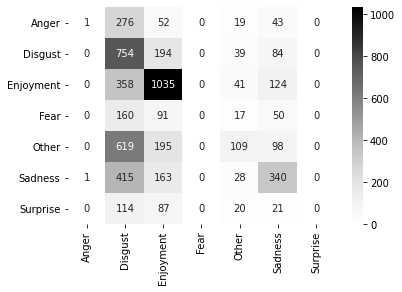

In [ ]:
# Confusion matrix
df_cm = pd.DataFrame(cf, index = np.unique(y_train),
                  columns = np.unique(y_train))

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})

# 2. PhoBERT


In [ ]:
# Read data

train = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/NLP_KHDL/ThucHanh_23042021/dataset/train_nor_811.xlsx", index_col=False)
dev = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/NLP_KHDL/ThucHanh_23042021/dataset/valid_nor_811.xlsx", index_col=False)
test = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/NLP_KHDL/ThucHanh_23042021/dataset/test_nor_811.xlsx", index_col=False)

X_train = train['Sentence']
y_train = train['Emotion'].values

X_dev = train['Sentence']
y_dev = train['Emotion'].values

X_test = train['Sentence']
y_test = train['Emotion'].values

print(len(train))
print(len(dev))
print(len(test))

5548
686
693


In [ ]:
# Pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 7)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
# Label encoding 
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
# Data encoding
train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
test_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
y_test_encoding = le.transform(y_test)

In [ ]:
# Data preparing

train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
# Model preparing

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
# Traning

trainer.train()

Step,Training Loss
500,1.494300
1000,0.857700


TrainOutput(global_step=1041, training_loss=1.1556341187754695, metrics={'train_runtime': 198.6671, 'train_samples_per_second': 5.24, 'total_flos': 539280200116800.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 139264, 'init_mem_gpu_alloc_delta': 540538880, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -49111040, 'train_mem_gpu_alloc_delta': 1633861120, 'train_mem_cpu_peaked_delta': 49147904, 'train_mem_gpu_peaked_delta': 472420352})

In [ ]:
# Prediction
y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

In [ ]:
# Evaluation
y_true = y_test_encoding

cf = confusion_matrix(y_true, y_pred)
print(cf)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

[[ 253  115    3   11    2    6    1]
 [  41  916   18   16   35   38    7]
 [   2   11 1479    7   29   17   13]
 [   6    9    8  277    7    9    2]
 [   7   39   68   14  821   40   32]
 [   1   16   23    5   16  879    7]
 [   1    3   34    3   13    1  187]]
F1 - micro: 0.8673395818312906
F1 - macro: 0.8361564785337503


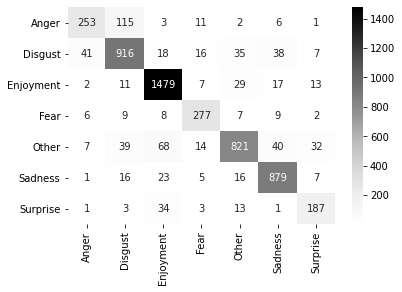

In [ ]:
# Confusion matrix
df_cm = pd.DataFrame(cf, index = np.unique(y_train),
                  columns = np.unique(y_train))

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})

## Compare: 

In [ ]:
XLM_micro = 0.4035688536409517
XLM_macro = 0.22651007200085144
PhoBERT_micro = 0.8673395818312906
PhoBERT_macro = 0.8361564785337503

In [ ]:
data = {'Model' : ["XML-R", "PhoBERT"] , 'F1 micro score' : [XLM_micro, PhoBERT_micro], 'F1 macro score' : [XLM_macro, PhoBERT_macro]}

After training 2 models : 
1. XLM-R (multilingual - included Vietnamese)
2. PhoBERT (monolingual - Vietnamese)

Model argument using :

    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False

Result :

In [ ]:
pd.DataFrame(data)

,Model,F1 micro score,F1 macro score
0,XML-R,0.403569,0.226510
1,PhoBERT,0.867340,0.836156


PhoBERT pre-trained model results better than XLM-R pre-trained model